In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import re
import string

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


## Loading training and test data

In [3]:
data_train = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
data_test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')
test_label = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip')
sample_submission = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip')

In [4]:
sample_submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.5,0.5,0.5,0.5,0.5,0.5
153160,fffd7a9a6eb32c16,0.5,0.5,0.5,0.5,0.5,0.5
153161,fffda9e8d6fafa9e,0.5,0.5,0.5,0.5,0.5,0.5
153162,fffe8f1340a79fc2,0.5,0.5,0.5,0.5,0.5,0.5


## Examine the data (EDA)

In [5]:
data_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [7]:
data_train['comment_text'][4]

"You, sir, are my hero. Any chance you remember what page that's on?"

In [8]:
sentences_length = data_train['comment_text'].map(lambda x: len(str(x)), na_action='ignore')
sentences_length.head()

0    264
1    112
2    233
3    622
4     67
Name: comment_text, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='comment_text', ylabel='Count'>

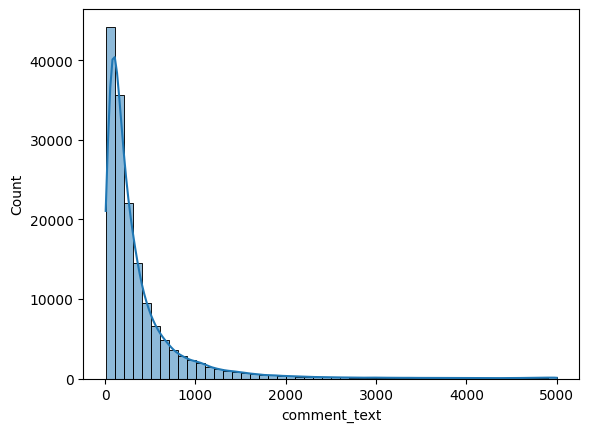

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(x = sentences_length, bins = 50, kde = True)

In [10]:
# !pip install nltk

In [86]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer  
from nltk.stem.wordnet import WordNetLemmatizer 
 
# lemmatizer = WordNetLemmatizer()
# nltk.download('punkt')
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
data_classify = {}
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for i, col in enumerate(classes):
    data_classify[col + '_cmt'] = data_train[data_train[col] == 1]['comment_text'].values
#     data_classify[col + '_cmt_len'] = [len(x) for x in data_classify[col + '_cmt']]
#     data_classify[col + '_cmt_word_count'] = [len(x.split()) for x in data_classify[col + '_cmt']]
#     data_classify[col + '_cmt_unique_word_count'] = [len(set(x.split())) for x in data_classify[col + '_cmt']]
#     data_classify[col + '_cmt_stopword_count'] = [len([w for w in x.split() if w in STOPWORDS]) for x in data_classify[col + '_cmt']]

In [13]:
# data_classify.head()

In [14]:
for col in classes:
    print(col, len(data_classify[col + '_cmt']))

toxic 15294
severe_toxic 1595
obscene 8449
threat 478
insult 7877
identity_hate 1405


## Visualize meta features of each class

In [15]:
# clean_cmt = data_train[data_train[classes].sum(axis = 1) == 0]
# clean_cmt
df = data_train.copy()
df['clean'] = (df.iloc[:,2:].sum(axis=1) == 0)

In [40]:
## Indirect features

#Sentense count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
    
META_FEATURES  = ['count_sent', 'count_word', 'count_unique_word', 'count_letters', 'count_punctuations', 'count_words_upper', 'count_words_title', 'count_stopwords', 'mean_word_len', 'word_unique_percent', 'punct_percent']
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

#### Rescale extreme cases

In [43]:
df.loc[df['count_sent']>10, 'count_sent'] = 10 
df.loc[df['count_word'] > 200, 'count_word'] = 200
df.loc[df['count_unique_word'] > 200, 'count_unique_word'] = 200
df.loc[df['count_letters'] > 1000, 'count_letters'] = 1000
df.loc[df['count_punctuations'] > 50, 'count_punctuations'] = 50
df.loc[df['count_words_upper'] > 30, 'count_words_upper'] = 30
df.loc[df['count_words_title'] > 30, 'count_words_title'] = 30
df.loc[df['count_stopwords'] > 100, 'count_stopwords'] = 100
df.loc[df['mean_word_len'] > 10, 'mean_word_len'] = 10
# df.loc[df['word_unique_percent'] > 100, 'word_unique_percent'] = 100
# df.loc[df['punct_percent'] > 10, 'punct_percent'] = 10

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


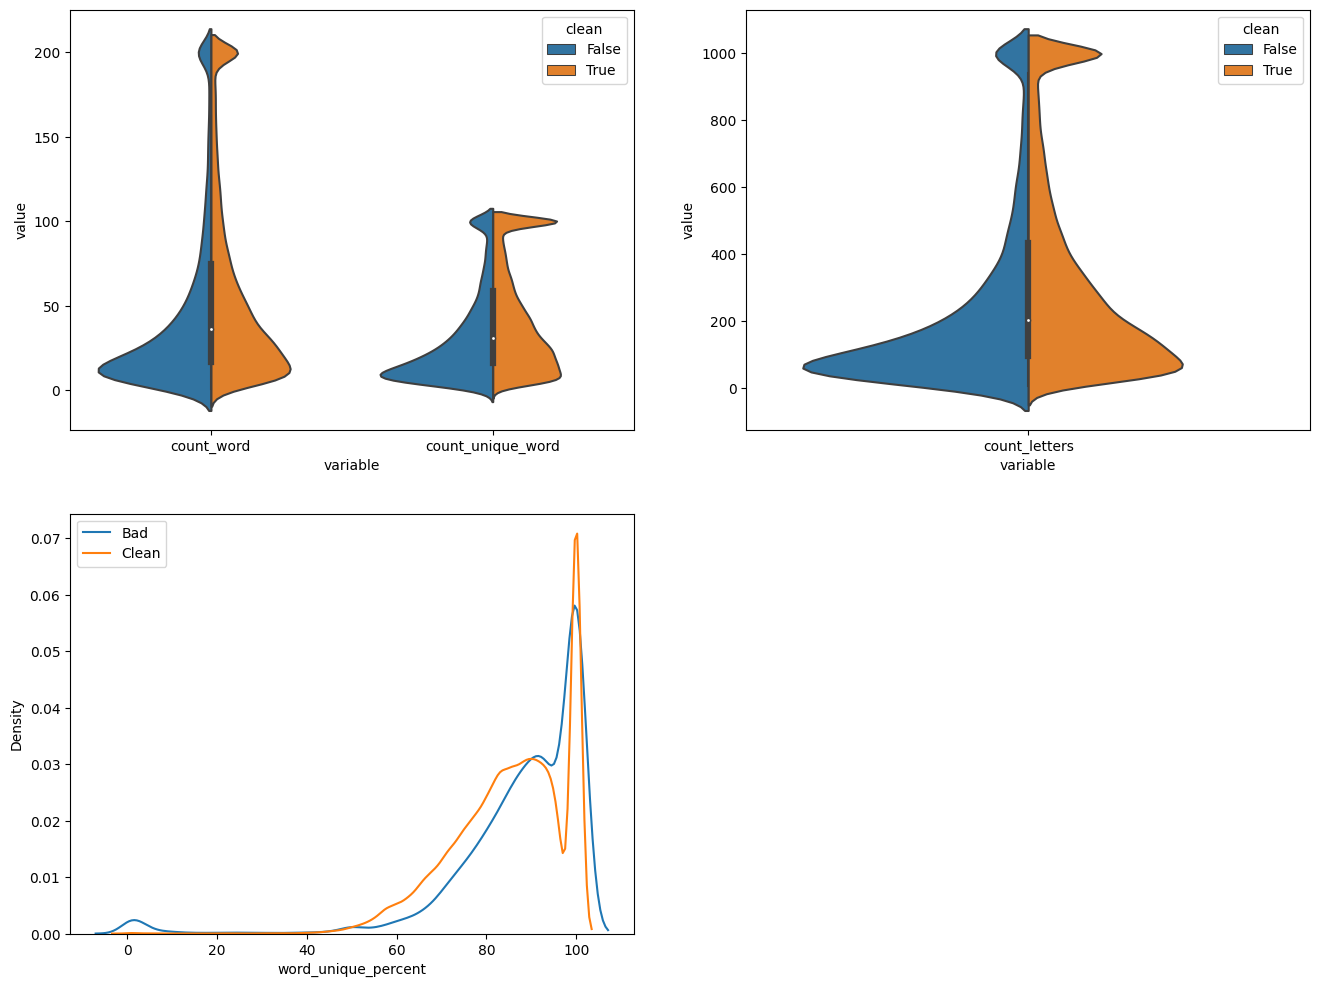

In [70]:
plt.figure(figsize=(16,12))
plt.subplot(2, 2, 1)
temp_df = pd.melt(df, value_vars=['count_word', 'count_unique_word'], id_vars='clean')
sns.violinplot(data=temp_df, y = 'value', x = 'variable', hue = 'clean', split = True, inner = 'quart')
plt.subplot(2, 2, 2)
temp_df = pd.melt(df, value_vars=['count_letters'], id_vars='clean')
sns.violinplot(data=temp_df, y = 'value', x = 'variable', hue = 'clean', split = True, inner = 'quart')
plt.subplot(2, 2, 3)
sns.kdeplot(df[df.clean == 0].word_unique_percent, label="Bad")
sns.kdeplot(df[df.clean == 1].word_unique_percent, label="Clean")
plt.legend()


In [ ]:
sns.violinplot(data=df, y = 'count_sent', x = 'clean')

### Length

In [ ]:
# plt.figure(figsize = (20, 15))
# feat = '_cmt_len'
# for i, col in enumerate(classes):
#     plt.subplot(2, 3, i + 1)
#     plt.title(col + feat)
#     for i, x in enumerate(data_classify[col + feat]):
#         if x > 1000:
#             data_classify[col + feat][i] = 1000
#     sns.violinplot(data_classify[col + feat])
# # plt.show()

### Word Count

In [ ]:
# plt.figure(figsize = (20, 15))
# feat = '_cmt_word_count'
# for i, col in enumerate(classes):
#     plt.subplot(2, 3, i + 1)
#     plt.title(col + feat)
#     for i, x in enumerate(data_classify[col + feat]):
#         if x > 200:
#             data_classify[col + feat][i] = 200
#     sns.violinplot(data_classify[col + feat])
# # plt.show()

### Unique Word Count

In [ ]:
# plt.figure(figsize = (20, 15))
# feat = '_cmt_unique_word_count'
# for i, col in enumerate(classes):
#     plt.subplot(2, 3, i + 1)
#     plt.title(col + feat)
#     for i, x in enumerate(data_classify[col + feat]):
#         if x > 100:
#             data_classify[col + feat][i] = 100
#     sns.violinplot(data_classify[col + feat])
# # plt.show()

## Correlation of features and targets

In [ ]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data_train[classes].astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

In [ ]:
# data_classify['identity_hate_cmt'].head(10)

## Clean the text

In [ ]:
# import re, string
# re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
# def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [82]:
import re

tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Remove \n
    text= re.sub("\\n","",text)
    # Remove leaky elements like ip,user
    text=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",text)
    # Removing usernames
    text=re.sub("\[\[.*\]","",text)
    # Remove emojis
#     text = re.sub(r'[\U00010000-\U0010ffff]', ' ', text, flags=re.UNICODE)
    
    # Remove punctuation
#     text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove numbers
    text = re.sub(r'\d', ' ', text)
    # tokenization
    words = tokenizer.tokenize(text)
    # lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    # Remove stopwords
    words = [word for word in words if word not in STOPWORDS]
    return text

In [73]:
data_classify['identity_hate_cmt']

array(["You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...\n\n1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!\n\n2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!\n\n3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!\n\nBeware of the Dark Side!",
       'A pair of jew-hating weiner nazi schmucks.',
       "I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms",
       ...,
       "Shalom \n\nSemite, get the fuck out of here. I will kill you, you son of a bitch if you don't leave wikipedia. If y

In [87]:
data_train['comment_text'] = data_train['comment_text'].apply(clean_text)
data_test['comment_text'] =data_test['comment_text'].apply(clean_text)
data_train.head()

LookupError: 
**********************************************************************
  Resource 'corpora/wordnet' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - '/root/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

## Split the data

In [ ]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(data_train, test_size = 0.2)
train_labels = train.drop(['id', 'comment_text'], axis = 1)
valid_labels = valid.drop(['id', 'comment_text'], axis = 1)

## Apply TF_IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
vec = TfidfVectorizer(ngram_range=(1,2),
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words = 'english')
# vec = CounVectorizer(stop_words = 'english')
trn_term_doc = vec.fit_transform(train['comment_text'])
val_term_doc = vec.transform(valid['comment_text'])
test_term_doc = vec.transform(data_test['comment_text'])
vec.get_feature_names_out()

In [ ]:
trn_term_doc, test_term_doc

In [ ]:
x = trn_term_doc
val_x = val_term_doc
del trn_term_doc
del val_term_doc
del train
del valid

## Modeling

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

In [ ]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    model = LogisticRegression()
    x_nb = x.multiply(r)
    return model.fit(x_nb, y), r

def get_model(y):
    y = y.values
    model = MultinomialNB()
    return model.fit(x, y)

In [ ]:
# preds = np.zeros((len(test), len(classes)))
model = []
for i, col in enumerate(classes):
    print(col)
    model.append(get_mdl(train_labels[col]))
    preds= model[i][0].predict_proba(val_x.multiply(model[i][1]))[:,1].reshape(-1, 1)
    print(roc_auc_score(valid_labels, preds))

In [ ]:
# preds = np.zeros((len(test), len(clas)))
# model = []
# for i, col in enumerate(classes):
#     print(col)
#     model.append(get_model(train_labels[col]))
#     preds= model[i].predict_proba(val_x)[:,1].reshape(-1, 1)
#     print(roc_auc_score(valid_labels, preds))

In [ ]:
preds = np.zeros((len(data_test), len(classes)))

for i, col in enumerate(classes):
    print(col)
    preds[:, i] = model[i].predict_proba(test_term_doc)[:, 1]

In [ ]:
submid = pd.DataFrame({'id': sample_submission["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = classes)], axis=1)
submission.to_csv('submission.csv', index=False)